In [46]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px

df = pd.read_table(r"Данные\Калибровка_041224_145832_.txt",  decimal='.')
df.head()

Timestamp       Current  Wavelength  Shutter
0  041224_145842  5.636900e-11         300      0.0
1  041224_145843  5.743200e-11         300      0.0
2  041224_145843  5.557400e-11         300      0.0
3  041224_145843  5.677800e-11         300      0.0
4  041224_145843  7.192100e-11         300      0.0

In [47]:
format_data = "%m%d%y_%H%M%S"

df["Time"] = df.Timestamp.apply( lambda x: datetime.strptime(x, format_data))
df["Time"] = df["Time"] - df["Time"][0]
df["Time"] = df["Time"].dt.total_seconds()
for i in range(int(df.Time[df.index[-1]])):
    pattern = np.linspace(0,1,len(df[df.Time == i]))
    df.loc[df.Time == i, "Time"] += pattern

df = df.loc[df.Wavelength >= 300][["Time", "Current", "Wavelength", "Shutter"]].copy(deep=True)
df



Time       Current  Wavelength  Shutter
0        0.000000  5.636900e-11         300      0.0
1        1.000000  5.743200e-11         300      0.0
2        1.090909  5.557400e-11         300      0.0
3        1.181818  5.677800e-11         300      0.0
4        1.272727  7.192100e-11         300      0.0
...           ...           ...         ...      ...
10809  978.000000  5.153920e-10         595      0.0
10810  978.000000  5.178290e-10         595      0.0
10811  978.000000  5.346380e-10         595      0.0
10812  978.000000  5.354970e-10         595      0.0
10813  978.000000  5.069820e-10         600      0.0

[10814 rows x 4 columns]

In [48]:
df["norm_current_uA"] = (df["Current"] - df["Current"].min())/(df["Current"].max() - df["Current"].min())
df["Shutter"] = df["Shutter"].shift(-23)
px.line(df, "Time", ["norm_current_uA","Shutter"])

In [49]:
calibration = pd.DataFrame([])
df = df.dropna()
for wavelength in df["Wavelength"].unique():
    mono_df = df.loc[df["Wavelength"] == wavelength]
    light_df = mono_df.loc[df.Shutter == 1, "Current"]
    light_df = light_df[10:-2]
    photocurrent = light_df.median() - mono_df[-50:]["Current"].median()
    new_row = pd.DataFrame({"Wavelength": wavelength, "Photocurrent": photocurrent}, index=[len(calibration)])
    calibration = pd.concat([calibration, new_row])
px.line(calibration, "Wavelength", ["Photocurrent"])

In [50]:
calibration.head()

Wavelength  Photocurrent
0         300  1.696116e-08
1         305  1.748010e-08
2         310  1.827192e-08
3         315  1.908373e-08
4         320  1.989553e-08

In [51]:
def p_diode(x):
  if x <= 500:
    y = 6.6763288698E-12*x**5 - 1.3543608284E-08*x**4 + 1.0888317706E-05*x**3 - 4.3335323943E-03*x**2 + 8.5399725862E-01*x - 6.6558844853E+01
  elif 500 <= x < 950:
    y = 5.5585093168E-04*x - 2.0552365026E-02
  elif 950 <= x <= 1100:
    y = 3.1698368227E-09*x**4 - 1.2731281453E-05*x**3 + 1.9132245041E-02*x**2 - 1.2752168975E+01*x + 3.1818412914E+03
  return y

In [52]:
IPCE_fin = pd.DataFrame([])

In [53]:
df = pd.read_table(r"Данные\DCV_042224_151536_.txt",  decimal=',')
format_data = "%m%d%y_%H%M%S"


df["Time"] = df.Timestamp.apply( lambda x: datetime.strptime(x, format_data))
df["Time"] = df["Time"] - df["Time"][0]
df["Time"] = df["Time"].dt.total_seconds()
for i in range(int(df.Time[df.index[-1]])):
    pattern = np.linspace(0,1,len(df[df.Time == i]))
    df.loc[df.Time == i, "Time"] += pattern
df = df.loc[df.Wavelength >= 300][["Time", "Current", "Wavelength", "Shutter"]].copy(deep=True)
#print(df)
IPCE_df = pd.DataFrame([])
df = df.dropna() 
for wavelength in df["Wavelength"].unique():
    mono_df = df.loc[df["Wavelength"] == wavelength]
    light_df = mono_df.loc[df.Shutter == 1, "Current"]
    light_df = light_df[10:-2]
    photocurrent = light_df.median() - mono_df[-100:-50]["Current"].median()
    new_row = pd.DataFrame({"Wavelength": wavelength, "Photocurrent": photocurrent}, index=[len(IPCE_df)])
    IPCE_df = pd.concat([IPCE_df, new_row])
px.line(IPCE_df, "Wavelength", ["Photocurrent"])
IPCE_df["K_diode"] = IPCE_df["Wavelength"].apply(p_diode)
IPCE_df["Мощность излучения, мкВт"] = calibration["Photocurrent"]/IPCE_df["K_diode"]
IPCE_df["IPCE"] = (IPCE_df["Photocurrent"]/7)*1240/IPCE_df["Wavelength"]/IPCE_df["Мощность излучения, мкВт"]*100
IPCE_fin["Wavelength"] = IPCE_df.Wavelength
IPCE_fin["1h"] = IPCE_df.IPCE
#IPCE_df
px.line(IPCE_df, "Wavelength", ["IPCE"])

In [54]:
px.line(df, "Time", ["Current"])

In [55]:
df = pd.read_table(r"Данные\DCV_042224_160805_.txt",  decimal=',')
format_data = "%m%d%y_%H%M%S"


df["Time"] = df.Timestamp.apply( lambda x: datetime.strptime(x, format_data))
df["Time"] = df["Time"] - df["Time"][0]
df["Time"] = df["Time"].dt.total_seconds()
for i in range(int(df.Time[df.index[-1]])):
    pattern = np.linspace(0,1,len(df[df.Time == i]))
    df.loc[df.Time == i, "Time"] += pattern
df = df.loc[df.Wavelength >= 300][["Time", "Current", "Wavelength", "Shutter"]].copy(deep=True)
#print(df)
IPCE_df = pd.DataFrame([])
df = df.dropna() 
for wavelength in df["Wavelength"].unique():
    mono_df = df.loc[df["Wavelength"] == wavelength]
    light_df = mono_df.loc[df.Shutter == 1, "Current"]
    light_df = light_df[10:-2]
    photocurrent = light_df[-120:-20].median() - mono_df[-300:-250]["Current"].median()
    new_row = pd.DataFrame({"Wavelength": wavelength, "Photocurrent": photocurrent}, index=[len(IPCE_df)])
    IPCE_df = pd.concat([IPCE_df, new_row])
px.line(IPCE_df, "Wavelength", ["Photocurrent"])
IPCE_df["K_diode"] = IPCE_df["Wavelength"].apply(p_diode)
IPCE_df["Мощность излучения, мкВт"] = calibration["Photocurrent"]/IPCE_df["K_diode"]
IPCE_df["IPCE"] = (IPCE_df["Photocurrent"]/(7))*1240/IPCE_df["Wavelength"]/IPCE_df["Мощность излучения, мкВт"]*100
IPCE_fin["5min"] = IPCE_df.IPCE
px.line(IPCE_df, "Wavelength", ["IPCE","Photocurrent"])

#IPCE_df

In [56]:
px.line(df, "Time", ["Current"])

In [57]:
df = pd.read_table(r"Данные\DCV_042224_172542_.txt",  decimal=',')
format_data = "%m%d%y_%H%M%S"


df["Time"] = df.Timestamp.apply( lambda x: datetime.strptime(x, format_data))
df["Time"] = df["Time"] - df["Time"][0]
df["Time"] = df["Time"].dt.total_seconds()
for i in range(int(df.Time[df.index[-1]])):
    pattern = np.linspace(0,1,len(df[df.Time == i]))
    df.loc[df.Time == i, "Time"] += pattern
df = df.loc[df.Wavelength >= 310][["Time", "Current", "Wavelength", "Shutter"]].copy(deep=True)
#print(df)
IPCE_df = pd.DataFrame([])
df = df.dropna() 
for wavelength in df["Wavelength"].unique():
    mono_df = df.loc[df["Wavelength"] == wavelength]
    light_df = mono_df.loc[df.Shutter == 1, "Current"]
    light_df = light_df[10:-2]
    photocurrent = light_df.median() - mono_df[-300:-100]["Current"].median()
    new_row = pd.DataFrame({"Wavelength": wavelength, "Photocurrent": photocurrent}, index=[len(IPCE_df)])
    IPCE_df = pd.concat([IPCE_df, new_row])
px.line(IPCE_df, "Wavelength", ["Photocurrent"])
IPCE_df["K_diode"] = IPCE_df["Wavelength"].apply(p_diode)
IPCE_df["Мощность излучения, мкВт"] = calibration["Photocurrent"]/IPCE_df["K_diode"]
IPCE_df["IPCE"] = (IPCE_df["Photocurrent"]/7)*1240/IPCE_df["Wavelength"]/IPCE_df["Мощность излучения, мкВт"]*100
IPCE_fin["3h"] = IPCE_df.IPCE
px.line(IPCE_df, "Wavelength", ["IPCE","Photocurrent"])
#IPCE_df

In [58]:
px.line(df, "Time", ["Current"])

In [59]:
df = pd.read_table(r"Данные\DCV_042224_181056_.txt",  decimal=',')
format_data = "%m%d%y_%H%M%S"


df["Time"] = df.Timestamp.apply( lambda x: datetime.strptime(x, format_data))
df["Time"] = df["Time"] - df["Time"][0]
df["Time"] = df["Time"].dt.total_seconds()
for i in range(int(df.Time[df.index[-1]])):
    pattern = np.linspace(0,1,len(df[df.Time == i]))
    df.loc[df.Time == i, "Time"] += pattern
df = df.loc[df.Wavelength >= 300][["Time", "Current", "Wavelength", "Shutter"]].copy(deep=True)
IPCE_df = pd.DataFrame([])
df = df.dropna() 
for wavelength in df["Wavelength"].unique():
    mono_df = df.loc[df["Wavelength"] == wavelength]
    light_df = mono_df.loc[df.Shutter == 1, "Current"]
    light_df = light_df[10:-2]
    photocurrent = light_df.median() - mono_df[-300:-250]["Current"].median()
    new_row = pd.DataFrame({"Wavelength": wavelength, "Photocurrent": photocurrent}, index=[len(IPCE_df)])
    IPCE_df = pd.concat([IPCE_df, new_row])
px.line(IPCE_df, "Wavelength", ["Photocurrent"])
IPCE_df["K_diode"] = IPCE_df["Wavelength"].apply(p_diode)
IPCE_df["Мощность излучения, мкВт"] = calibration["Photocurrent"]/IPCE_df["K_diode"]
IPCE_df["IPCE"] = (IPCE_df["Photocurrent"]/7)*1240/IPCE_df["Wavelength"]/IPCE_df["Мощность излучения, мкВт"]*100
IPCE_fin["1h - пробитый"] = IPCE_df.IPCE
px.line(IPCE_df, "Wavelength", ["IPCE","Photocurrent"])

In [60]:
px.line(df, "Time", ["Current"])

<Axes: xlabel='Wavelength'>

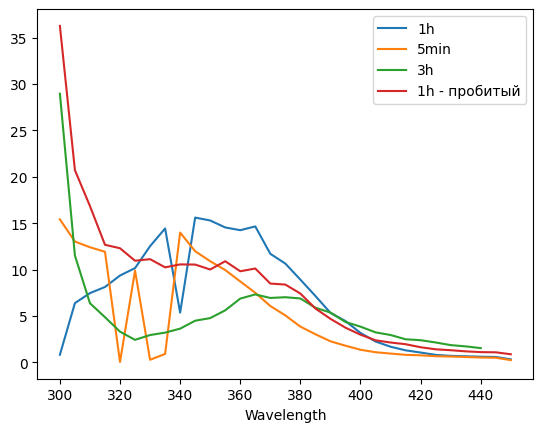

In [61]:
IPCE_fin.plot(x="Wavelength")

In [62]:
IPCE_fin.to_excel("IPCE.xlsx")